<a href="https://colab.research.google.com/github/VectorTensor/MachineLearningNotebooks/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install transformers
!pip install datasets

In [27]:
from datasets import load_dataset
import torch

In [28]:
emotions  = load_dataset('emotion')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [29]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [31]:
emotions['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [32]:
emotions.set_format(type="pandas")

In [33]:
df = emotions["train"][:]

df_val = emotions["validation"][:]
df_test = emotions["test"][:]

In [34]:
df.iloc[5]


text     ive been feeling a little burdened lately wasn...
label                                                    0
Name: 5, dtype: object

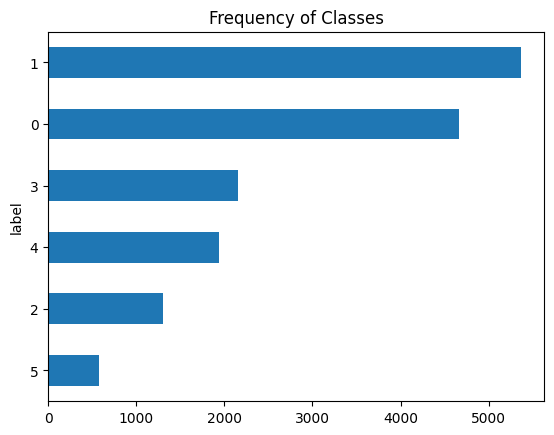

In [35]:
import matplotlib.pyplot as plt

df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()




In [36]:
from torch.utils.data import Dataset

In [37]:
import torch

In [38]:
import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

In [39]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    'distilbert-base-uncased'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
train_texts = df['text'].values
train_labels = df['label'].values
valid_texts = df_val['text'].values
test_texts = df_test['text'].values
valid_labels = df_val['label'].values
test_labels = df_test['label'].values

In [41]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts),truncation = True, padding = True)
test_encodings = tokenizer(list(test_texts), truncation = True, padding = True)


In [42]:
class EmotionDataset(Dataset):
    def __init__(self, encodings,labels):
        self.encoding = encodings
        self.labels = labels

    def __getitem__(self,idx):
        item =  {key:torch.tensor(val[idx]) for key,val in self.encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)



In [43]:
train_dataset = EmotionDataset(train_encodings,train_labels)
valid_dataset = EmotionDataset(valid_encodings,valid_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

In [44]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)


In [45]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels = 6
)
model.to(DEVICE)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [46]:
model.train()
optim = torch.optim.Adam(model.parameters(), lr=5e-5)


In [47]:
def compute_accuracy(model, data_loader,device):
    with torch.no_grad():
        correct_pred, num_examples = 0,0
        for batch_idx, batch in enumerate(data_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask = attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

    return correct_pred.float()/num_examples * 100




In [48]:
import time

In [49]:
start_time = time.time()
NUM_EPOCHS = 4


In [50]:
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch  in enumerate(train_loader):

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

        loss, logits = outputs['loss'], outputs['logits']

        optim.zero_grad()
        loss.backward()
        optim.step()

        if not batch_idx % 250:
            print(f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d}'
                f' | Batch'
                f'{batch_idx:04d}/'
                f'{len(train_loader):04d} | '
                f'Loss: {loss:.4f}')

    model.eval()

    with torch.set_grad_enabled(False):
        print(f'Training accuracy: '
         f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
         f'\nValid accuracy: '
         f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

    print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
    print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 0001/0004 | Batch0000/1000 | Loss: 1.7787
Epoch: 0001/0004 | Batch0250/1000 | Loss: 0.5249
Epoch: 0001/0004 | Batch0500/1000 | Loss: 0.3573
Epoch: 0001/0004 | Batch0750/1000 | Loss: 0.4987
Training accuracy: 94.21%
Valid accuracy: 93.05%
Time elapsed: 2.76 min
Total Training Time: 2.76 min
Test accuracy: 92.45%
Epoch: 0002/0004 | Batch0000/1000 | Loss: 0.1308
Epoch: 0002/0004 | Batch0250/1000 | Loss: 0.2707
Epoch: 0002/0004 | Batch0500/1000 | Loss: 0.4481
Epoch: 0002/0004 | Batch0750/1000 | Loss: 0.2556
Training accuracy: 95.03%
Valid accuracy: 92.85%
Time elapsed: 5.56 min
Total Training Time: 5.56 min
Test accuracy: 92.80%
Epoch: 0003/0004 | Batch0000/1000 | Loss: 0.3208
Epoch: 0003/0004 | Batch0250/1000 | Loss: 0.0056
Epoch: 0003/0004 | Batch0500/1000 | Loss: 0.0494
Epoch: 0003/0004 | Batch0750/1000 | Loss: 0.0134
Training accuracy: 96.53%
Valid accuracy: 94.05%
Time elapsed: 8.36 min
Total Training Time: 8.36 min
Test accuracy: 93.15%
Epoch: 0004/0004 | Batch0000/1000 | Loss

In [61]:
from torch import Tensor

In [74]:
def compute_preds(model, data_loader,device):
    with torch.no_grad():
        correct_pred, num_examples = 0,0
        preds = []
        labs = []
        for batch_idx, batch in enumerate(data_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask = attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            preds +=predicted_labels.tolist()
            labs += labels.tolist()

    return preds, labs

In [75]:
preds, labs= compute_preds(model, test_loader, DEVICE)

In [76]:
labels =["sadness","joy", "love","anger","feat","suprise"]

In [77]:
preds[0]

1

In [78]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_preds = preds
cm = confusion_matrix(labs, y_preds,normalize="true")
dis = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels= labels)

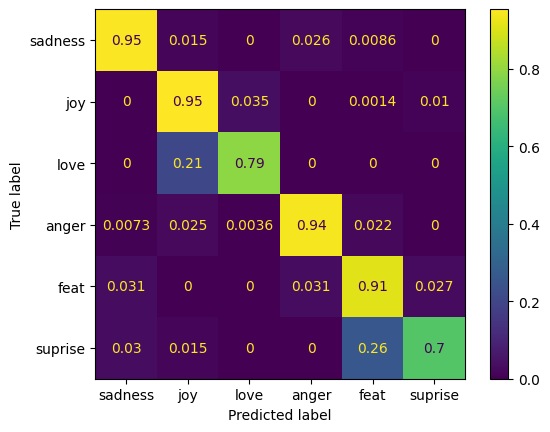

In [79]:
dis.plot()

In [80]:
from sklearn.metrics import classification_report

print(classification_report(labs, y_preds, target_names = labels))

              precision    recall  f1-score   support

     sadness       0.98      0.95      0.97       581
         joy       0.93      0.95      0.94       695
        love       0.83      0.79      0.81       159
       anger       0.92      0.94      0.93       275
        feat       0.88      0.91      0.89       224
     suprise       0.78      0.70      0.74        66

    accuracy                           0.93      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.92      0.93      0.92      2000

